In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_345_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_32_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_233_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_200_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_161_0110.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_47_1100.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_235_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_277_1100.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_199_0011.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_231_1011.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/train

In [2]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
real_dir = '../input/real-and-fake-face-detection/real_and_fake_face/training_real/'
real_path = os.listdir(real_dir)

fake_dir = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/'
fake_path = os.listdir(fake_dir)

In [4]:
def load_img(path):
    '''Loading images from directory 
    and changing color space from cv2 standard BGR to RGB 
    for better visualization'''
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

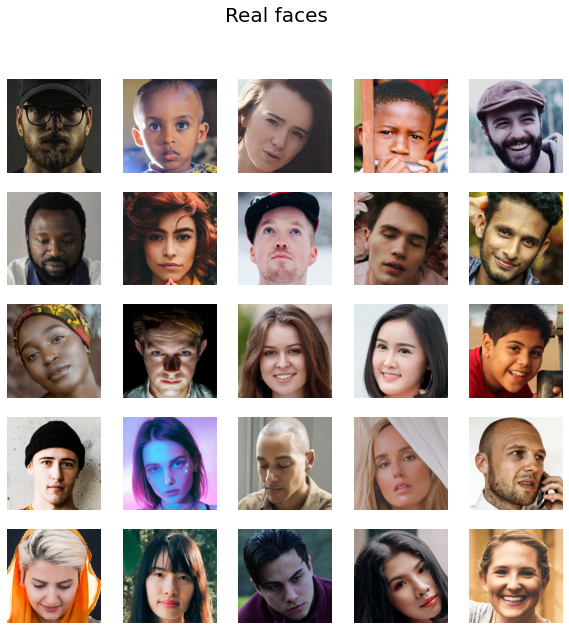

In [5]:
fig = plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(real_dir + real_path[i]))
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')

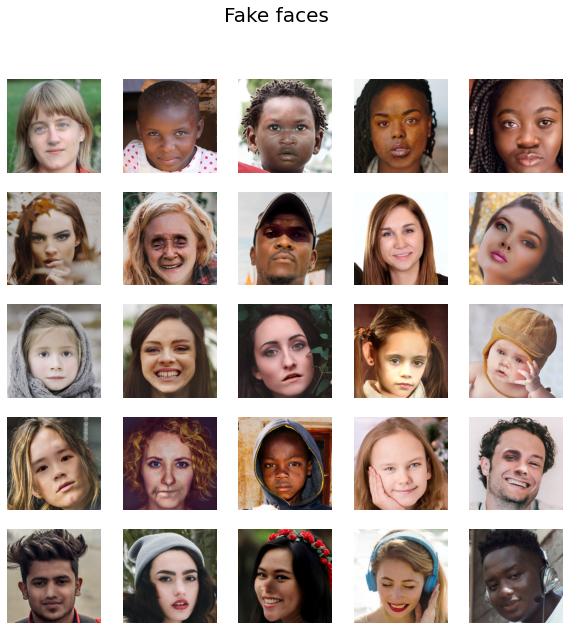

In [6]:
fig = plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(fake_dir + fake_path[i]))
    plt.suptitle("Fake faces", fontsize=20)
    plt.axis('off')

In [7]:
real_df = pd.DataFrame({'image_path': real_dir + real_path[i], 'label': 1} for i in range(0, 1081))
fake_df = pd.DataFrame({'image_path': fake_dir + fake_path[i], 'label': 0} for i in range(0, 960))

In [8]:
df = pd.concat([real_df, fake_df], ignore_index=True)
df.tail(10)

image_path  label
2031  ../input/real-and-fake-face-detection/real_and...      0
2032  ../input/real-and-fake-face-detection/real_and...      0
2033  ../input/real-and-fake-face-detection/real_and...      0
2034  ../input/real-and-fake-face-detection/real_and...      0
2035  ../input/real-and-fake-face-detection/real_and...      0
2036  ../input/real-and-fake-face-detection/real_and...      0
2037  ../input/real-and-fake-face-detection/real_and...      0
2038  ../input/real-and-fake-face-detection/real_and...      0
2039  ../input/real-and-fake-face-detection/real_and...      0
2040  ../input/real-and-fake-face-detection/real_and...      0

In [9]:
df = shuffle(df)
df = df.reset_index(drop=True)
df.head(10)

image_path  label
0  ../input/real-and-fake-face-detection/real_and...      0
1  ../input/real-and-fake-face-detection/real_and...      1
2  ../input/real-and-fake-face-detection/real_and...      0
3  ../input/real-and-fake-face-detection/real_and...      1
4  ../input/real-and-fake-face-detection/real_and...      1
5  ../input/real-and-fake-face-detection/real_and...      0
6  ../input/real-and-fake-face-detection/real_and...      0
7  ../input/real-and-fake-face-detection/real_and...      1
8  ../input/real-and-fake-face-detection/real_and...      1
9  ../input/real-and-fake-face-detection/real_and...      0

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
image_size = 224
batch_size = 64
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
image_transforms = {'train_transform': A.Compose([A.Resize(image_size, image_size), 
                                                  A.HorizontalFlip(p=0.5), 
                                                  A.RandomBrightnessContrast(always_apply=False, 
                                                                             p=0.4),
                                                  A.Solarize(always_apply=False, 
                                                             p=0.4, 
                                                             threshold=(42, 42)),
                                                  A.MultiplicativeNoise(always_apply=False, 
                                                                        p=0.8, 
                                                                        multiplier=(0.6800000071525574, 1.409999966621399), 
                                                                        per_channel=True, 
                                                                        elementwise=True),
                                                  A.Normalize(mean=(0.485, 0.456, 0.406), 
                                                              std=(0.229, 0.224, 0.225), 
                                                              max_pixel_value=255.0, 
                                                              p=1.0), 
                                                  ToTensorV2()]),
                    
                   'validation_transform': A.Compose([A.Resize(image_size, image_size), 
                                                      A.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                  std=(0.229, 0.224, 0.225), 
                                                                  max_pixel_value=255.0, 
                                                                  p=1.0), 
                                                      ToTensorV2()]),
                   'visualization_transform': A.Compose([A.Resize(image_size, image_size), 
                                                         A.HorizontalFlip(p=0.5), 
                                                         A.RandomBrightnessContrast(always_apply=False, 
                                                                                    p=0.4),
                                                  A.Solarize(always_apply=False, 
                                                             p=0.4, 
                                                             threshold=(42, 42)),
                                                  A.MultiplicativeNoise(always_apply=False, 
                                                                        p=0.8, 
                                                                        multiplier=(0.6800000071525574, 1.409999966621399), 
                                                                        per_channel=True, 
                                                                        elementwise=True)])}


In [13]:
class ImageDataset(Dataset):
    def __init__(self, image_labels, image_dir, transform=None, target_transform=None):
        self.image_labels = image_labels
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        
        
    def __len__(self):
        return len(self.image_labels)
    
    
    def __getitem__(self, index):
        image_path = self.image_dir.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.image_labels.iloc[index]
        if self.transform:
            image = self.transform(image=image)['image']
        if self.target_transform:
            label = self.target_transform(label=label)
        return image, label

In [14]:
train_label = train_df['label']
train_features = train_df['image_path']

val_label = val_df['label']
val_features = val_df['image_path']

train_dataset = ImageDataset(train_label, 
                             train_features, 
                             transform=image_transforms['train_transform'])
val_dataset = ImageDataset(val_label, 
                           val_features, 
                           transform=image_transforms['validation_transform'])
visual_train_dataset =  ImageDataset(train_label, 
                                     train_features, 
                                     transform=image_transforms['visualization_transform'])

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
visual_loader = DataLoader(visual_train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
val_loader

In [17]:
visual_train_f, visual_train_t = next(iter(visual_loader))
print(f'Feature batch shape: {visual_train_f.size()}')
print(f'Target batch shape: {visual_train_t.size()}')

Feature batch shape: torch.Size([64, 224, 224, 3])
Target batch shape: torch.Size([64])


In [18]:
for item in visual_loader:
    img, label = item[0], item[1]
    print(img, label)

tensor([[[[132, 131, 136],
          [132, 130, 136],
          [132, 131, 136],
          ...,
          [117, 118, 123],
          [116, 117, 122],
          [111, 114, 122]],

         [[131, 130, 135],
          [133, 132, 138],
          [132, 131, 136],
          ...,
          [119, 118, 123],
          [119, 119, 124],
          [119, 120, 124]],

         [[132, 131, 136],
          [133, 132, 138],
          [132, 131, 136],
          ...,
          [121, 119, 122],
          [120, 118, 121],
          [120, 119, 124]],

         ...,

         [[ 89,  84,  80],
          [ 89,  84,  80],
          [ 89,  84,  80],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[ 91,  86,  82],
          [ 91,  86,  82],
          [ 91,  86,  82],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[ 91,  86,  82],
          [ 91,  86,  82],
          [ 90,  85,  81],
         

In [19]:
def plot_batch(features, target, batch_size=batch_size):
    '''Shows one batch of augmented images'''
    plt.figure(figsize=(10, 40))
    for i in range(batch_size):
        img = features[i]
        label = target[i]
        
        plt.subplot(16, 4, i+1)
        plt.title(f'Class: {label}')
        plt.imshow(img)
    plt.show()

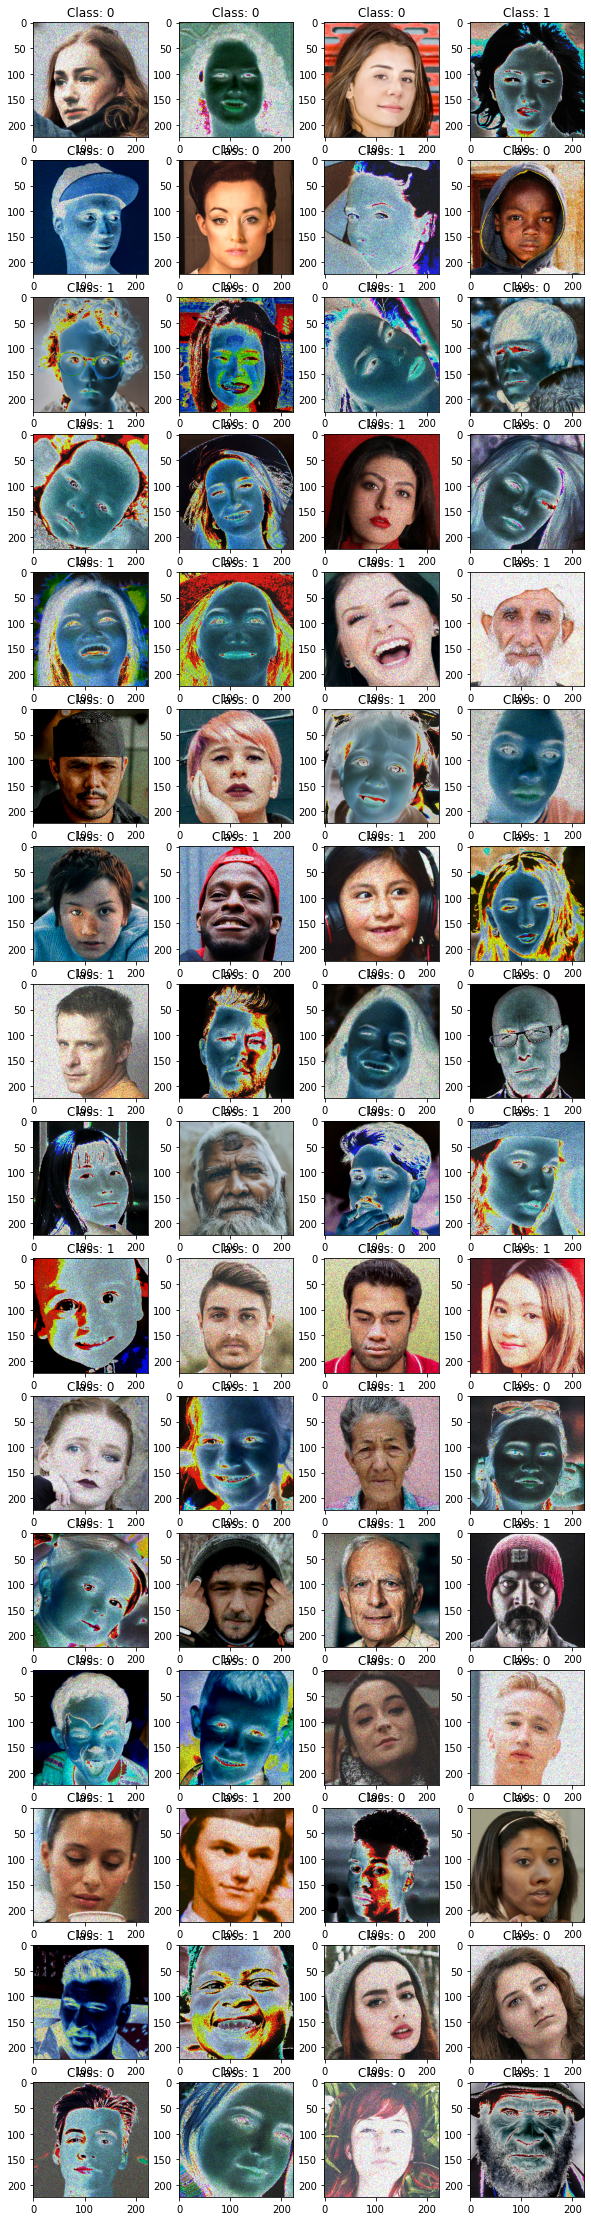

In [20]:
plot_batch(visual_train_f, visual_train_t)

In [21]:
class FaceNet(nn.Module):
    def __init__(self):
        super(FaceNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=18, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.batchnorm_1 = nn.BatchNorm2d(18)
        self.conv_2 = nn.Conv2d(in_channels=18, out_channels=18, kernel_size=3)
        self.batchnorm_2 = nn.BatchNorm2d(18)
        self.conv_3 = nn.Conv2d(in_channels=18, out_channels=32, kernel_size=3)
        self.fc_1 = nn.Linear(21632, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.maxpool(nn.functional.relu(self.conv_1(x)))
        x = self.maxpool(nn.functional.relu(self.conv_2(x)))
        x = self.maxpool(nn.functional.relu(self.conv_3(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc_1(x))
        x = nn.functional.relu(self.fc_2(x))
        x = torch.sigmoid(self.classifier(x))
        return x

In [22]:
model_custom = FaceNet()
model_custom.to(device)

FaceNet(
  (conv_1): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm_1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm_2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(18, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=21632, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
criterion_custom = torch.nn.BCELoss()
optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler_custom = torch.optim.lr_scheduler.ExponentialLR(optimizer_custom, gamma=0.9)

In [24]:
def training_loop(model, training_loader, validation_loader, criterion, optimizer, scheduler, epochs=num_epochs):
    '''Training loop for train and eval modes'''
    for epoch in range(1, epochs+1):
        model.train()
        train_accuracy = 0
        train_loss = 0
        for image, target in training_loader:
            image = image.to(device)
            target = target.to(device)
            target = target.unsqueeze(1)
            optimizer.zero_grad()
            outputs = torch.sigmoid(model(image))
            loss = criterion(outputs.float(), target.float())
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += ((outputs > 0.5) == target).float().mean().item()
            
        with torch.no_grad():
            model.eval()
            valid_loss = 0
            val_accuracy = 0
            for val_image, val_target in validation_loader:
                val_image = val_image.to(device)
                val_target = val_target.to(device)
                val_target = val_target.unsqueeze(1)
                val_outputs = torch.sigmoid(model(val_image))
                val_loss = criterion(val_outputs.float(), val_target.float())
                
                valid_loss += val_loss.item()
                val_accuracy += ((val_outputs > 0.5) == val_target).float().mean().item() 
                
        print(f'Epoch: {epoch} Train loss: {train_loss/len(training_loader)} Train accuracy: {train_accuracy /len(training_loader)} Val loss: {valid_loss/len(validation_loader)} Val accuracy: {val_accuracy/len(validation_loader)}')
        scheduler.step()

In [25]:
training_loop(model_custom, 
              train_loader, 
              val_loader, 
              criterion_custom, 
              optimizer_custom, 
              scheduler_custom, 
              epochs=num_epochs)

Epoch: 1 Train loss: 0.69416511288056 Train accuracy: 0.5294471153846154 Val loss: 0.6906701922416687 Val accuracy: 0.5283928556101662
Epoch: 2 Train loss: 0.6913606639091785 Train accuracy: 0.5294471153846154 Val loss: 0.6887792944908142 Val accuracy: 0.5353571431977409
Epoch: 3 Train loss: 0.6897345735476568 Train accuracy: 0.5282451923076923 Val loss: 0.690794050693512 Val accuracy: 0.5214285680225917
Epoch: 4 Train loss: 0.6901027468534616 Train accuracy: 0.5288461538461539 Val loss: 0.6887540987559727 Val accuracy: 0.5249107139451163
Epoch: 5 Train loss: 0.6892651938475095 Train accuracy: 0.5294471153846154 Val loss: 0.6863721438816616 Val accuracy: 0.5318749972752163
Epoch: 6 Train loss: 0.6889675603463099 Train accuracy: 0.5282451923076923 Val loss: 0.6841488991464887 Val accuracy: 0.5353571431977409
Epoch: 7 Train loss: 0.6895579030880561 Train accuracy: 0.5264423076923077 Val loss: 0.6859130774225507 Val accuracy: 0.5249107139451163
Epoch: 8 Train loss: 0.6865185567965875 Trai

In [26]:
model_np = models.resnet50(pretrained=False)
model_np.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=512, bias=True), 
                     nn.ReLU(inplace=True),
                     nn.Linear(in_features=512, out_features=1, bias=True))

model_np.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
criterion_np = torch.nn.BCELoss()
optimizer_np = torch.optim.Adam(model_np.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler_np = torch.optim.lr_scheduler.ExponentialLR(optimizer_np, gamma=0.9)

In [28]:
training_loop(model_np, 
              train_loader, 
              val_loader, 
              criterion_np, 
              optimizer_np, 
              scheduler_np, 
              epochs=num_epochs)

Epoch: 1 Train loss: 0.6924966069368216 Train accuracy: 0.5186298076923077 Val loss: 0.691413130078997 Val accuracy: 0.5321428520338876
Epoch: 2 Train loss: 0.6989030723388379 Train accuracy: 0.49278846153846156 Val loss: 0.6921194621494838 Val accuracy: 0.5353571431977409
Epoch: 3 Train loss: 0.6952090721863967 Train accuracy: 0.53125 Val loss: 0.6910308684621539 Val accuracy: 0.5388392806053162
Epoch: 4 Train loss: 0.6916995186072129 Train accuracy: 0.5306490384615384 Val loss: 0.6911961776869637 Val accuracy: 0.5388392806053162
Epoch: 5 Train loss: 0.6918343764085036 Train accuracy: 0.5324519230769231 Val loss: 0.6896994880267552 Val accuracy: 0.5423214265278408
Epoch: 6 Train loss: 0.6915623132999127 Train accuracy: 0.5306490384615384 Val loss: 0.6918084025382996 Val accuracy: 0.5318749972752163
Epoch: 7 Train loss: 0.6927716456926786 Train accuracy: 0.5252403846153846 Val loss: 0.6909823587962559 Val accuracy: 0.5388392806053162
Epoch: 8 Train loss: 0.6913417669442984 Train accura

In [29]:
model_p = models.resnet50(pretrained=True)
model_p.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=512, bias=True), 
                     nn.ReLU(inplace=True),
                     nn.Linear(in_features=512, out_features=1, bias=True))
for param in model_p.parameters():
    param.requires_grad = True
model_p.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
criterion_p = torch.nn.BCELoss()
optimizer_p = torch.optim.Adam(model_p.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler_p = torch.optim.lr_scheduler.ExponentialLR(optimizer_p, gamma=0.9)

In [31]:
training_loop(model_p, 
              train_loader, 
              val_loader, 
              criterion_p, 
              optimizer_p, 
              scheduler_p, 
              epochs=num_epochs)

Epoch: 1 Train loss: 0.6899731434308566 Train accuracy: 0.5246394230769231 Val loss: 0.6845732246126447 Val accuracy: 0.5773214272090367
Epoch: 2 Train loss: 0.6790890235167283 Train accuracy: 0.5799278846153846 Val loss: 0.6805576596941266 Val accuracy: 0.5723214234624591
Epoch: 3 Train loss: 0.6645969633872693 Train accuracy: 0.6105769230769231 Val loss: 0.6772841129984174 Val accuracy: 0.5765178544180733
Epoch: 4 Train loss: 0.6464156325046833 Train accuracy: 0.6538461538461539 Val loss: 0.6690799168178013 Val accuracy: 0.5844642860548837
Epoch: 5 Train loss: 0.6282010743251214 Train accuracy: 0.6568509615384616 Val loss: 0.6614498325756618 Val accuracy: 0.6035714234624591
Epoch: 6 Train loss: 0.6017301839131576 Train accuracy: 0.7043269230769231 Val loss: 0.6570354274341038 Val accuracy: 0.5869642836706979
Epoch: 7 Train loss: 0.5864968666663537 Train accuracy: 0.6977163461538461 Val loss: 0.6676203182765416 Val accuracy: 0.5797321413244519
Epoch: 8 Train loss: 0.570947683774508 Tr

In [34]:
!pip install torchcam
from torchcam.methods import GradCAMpp
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

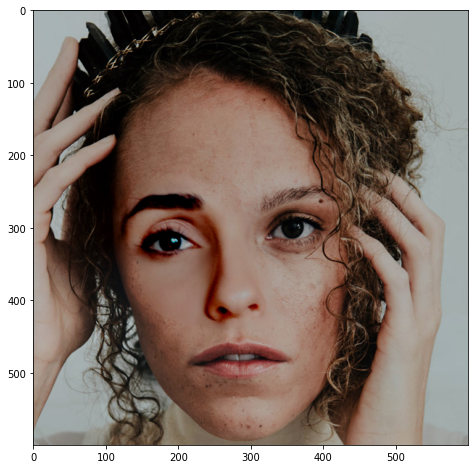

In [41]:
img_path = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_13_1010.jpg'
img = read_image(img_path)
fig = plt.figure(figsize=(8, 8))
plt.imshow(to_pil_image(img))

In [42]:
def saliency_map(image_path, model, shape, model_name):
    '''Drawing saliency heatmap for one loaded image'''
    model.to(device)
    model.eval()

    image = read_image(img_path)

    image = resize(image, (224, 224))
    image = image.clone().detach()
    image = image.unsqueeze(0)
    image = image.to(device)
    image = image.float()
    image.requires_grad_()

    output = model(image)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.reshape(shape)

    fig = plt.figure(figsize=(8, 8))
    plt.imshow(saliency.cpu(), origin='upper', cmap='inferno')
    plt.title(model_name)

In [43]:
def grad_mask_vizualiser(img_path, model, model_name):
    '''Drawing a visualization of GradCAM cnn explanation method,
    that shows where in the image are the most important features 
    for neural network'''
    model.eval()
    cam_extractor = GradCAMpp(model, 'layer4')
    img = read_image(img_path)
    input_tensor = normalize(resize(img, (224, 224)) / 255.0, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    input_tensor = input_tensor.to(device)
    out = model(input_tensor.unsqueeze(0).cuda())
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)
    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        plt.imshow(result)
        plt.axis('off')
        plt.title(model_name)

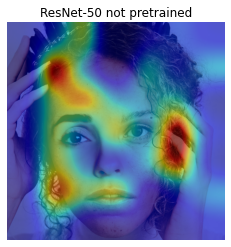

In [44]:
grad_mask_vizualiser(img_path, model_np, 'ResNet-50 not pretrained')    

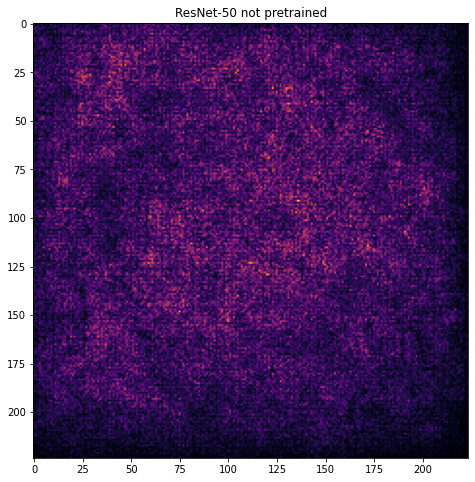

In [45]:
saliency_map(img_path, model_np, (224, 224), 'ResNet-50 not pretrained')

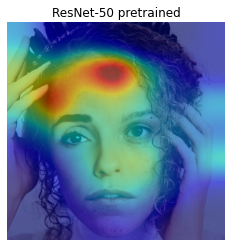

In [46]:
grad_mask_vizualiser(img_path, model_p, 'ResNet-50 pretrained')  

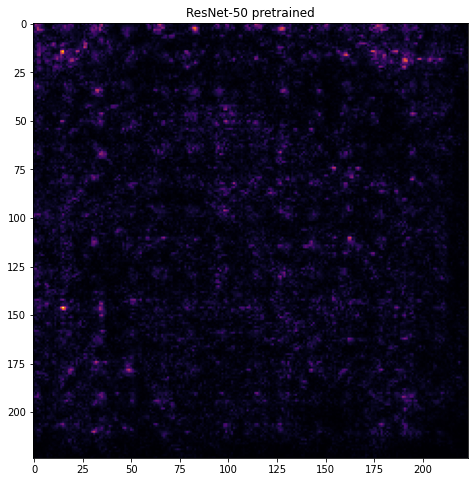

In [47]:
saliency_map(img_path, model_p, (224, 224), 'ResNet-50 pretrained')

In [48]:
model_np = models.resnet50(pretrained=False)
model_np.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=512, bias=True), 
                     nn.ReLU(inplace=True),
                     nn.Linear(in_features=512, out_features=1, bias=True))

model_np.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
criterion_np = torch.nn.BCELoss()
optimizer_np = torch.optim.Adam(model_np.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler_np = torch.optim.lr_scheduler.ExponentialLR(optimizer_np, gamma=0.9)

In [50]:
training_loop(model_np, 
              train_loader, 
              val_loader, 
              criterion_np, 
              optimizer_np, 
              scheduler_np, 
              epochs=num_epochs)

Epoch: 1 Train loss: 0.6966910155919882 Train accuracy: 0.5204326923076923 Val loss: 0.6921456456184387 Val accuracy: 0.533125000340598
Epoch: 2 Train loss: 0.6977619689244491 Train accuracy: 0.5210336538461539 Val loss: 0.6907810909407479 Val accuracy: 0.5586607115609306
Epoch: 3 Train loss: 0.6968119419538058 Train accuracy: 0.49759615384615385 Val loss: 0.6913311226027352 Val accuracy: 0.5226785710879734
Epoch: 4 Train loss: 0.6945454547038445 Train accuracy: 0.5180288461538461 Val loss: 0.6994019491331918 Val accuracy: 0.5144642846924918
Epoch: 5 Train loss: 0.695890309718939 Train accuracy: 0.5024038461538461 Val loss: 0.6890943305832999 Val accuracy: 0.5410714234624591
Epoch: 6 Train loss: 0.6914409353182867 Train accuracy: 0.5300480769230769 Val loss: 0.6935419866016933 Val accuracy: 0.5214285680225917
Epoch: 7 Train loss: 0.691859653362861 Train accuracy: 0.5306490384615384 Val loss: 0.6920457141739982 Val accuracy: 0.5299107091767448
Epoch: 8 Train loss: 0.6937230045978839 Tra

In [56]:
!pip install argparse
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
import argparse
import cv2

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [57]:
from tensorflow import keras

In [68]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_13_1010.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n03476991', 'hair_spray', 0.67232615), ('n04584207', 'wig', 0.0777788), ('n03814639', 'neck_brace', 0.05249663)]


In [69]:
from tensorflow.keras.preprocessing import image
model = VGG16(weights='imagenet', include_top=False)

img_path = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_13_1010.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

In [71]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization




# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(17))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

In [72]:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [78]:
IMAGE_SIZE = [224, 224]

train_path = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_13_1010.jpg'
valid_path = 'Datasets/test'

In [79]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [87]:
for layer in vgg16.layers:
    layer.trainable = False

In [88]:
x = Flatten()(vgg16.output)

In [89]:
prediction = Dense(len(train_path), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [90]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [96]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [97]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [99]:
training_fake = train_datagen.flow_from_directory('../input/real-and-fake-face-detection/real_and_fake_face/training_fake/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 0 images belonging to 0 classes.


In [ ]:
real_dir = '../input/real-and-fake-face-detection/real_and_fake_face/training_real/'
real_path = os.listdir(real_dir)

fake_dir = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/'
fake_path = os.listdir(fake_dir)